In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16 as PTM, preprocess_input
from tensorflow.keras import backend as bk
import numpy as np
from tensorflow import keras
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/train'
test_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/test'
gt_path = '/content/drive/MyDrive/GreatLearning/Hackthon/HDFCLife/GroundTruth/Gt.csv'

In [3]:
target_size= (128,128)
batch_size = 5
epochs = 10 * 2

In [4]:
test_dataset = []
file_ids = []
testData =  glob.glob('{}/*.jpg'.format(test_path))
for data in testData:
  img = tf.keras.preprocessing.image
  image = img.load_img(data, color_mode='rgb', target_size= target_size)
  image = np.array(image)
  file_id = os.path.basename(data).replace('.jpg', '')
  test_dataset.append(image)
  file_ids.append(int(file_id))

In [5]:
file_ids[10]

1

In [6]:
imageDataGen = ImageDataGenerator(rescale= 1./ 255,
                                 shear_range= 0.2,
                                 zoom_range=0.2, 
                                 horizontal_flip=True, 
                                 validation_split=0.2,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 fill_mode="nearest",
                                 preprocessing_function=preprocess_input)



train_generator = imageDataGen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = imageDataGen.flow_from_directory(
    train_path, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


Found 473 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [7]:
train_generator.class_indices

{'Mask': 0, 'NoMask': 1}

In [8]:
pd.DataFrame(train_generator.classes, columns=['Classes']).value_counts()

Classes
0          384
1           89
dtype: int64

In [9]:
pd.DataFrame(validation_generator.classes, columns=['Classes']).value_counts()

Classes
0          96
1          22
dtype: int64

In [10]:
ptm = PTM(input_shape=tuple(list(target_size)+[3]),
            weights='imagenet', 
            include_top=False)
ptm.trainable = False 

In [11]:
ptm.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
model = Sequential()
model.add(ptm)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(.5))
model.add(Dense(512,activation='relu')) 
model.add(Dropout(.5))
model.add(Dense(256,activation='relu')) 
model.add(Dropout(.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2,activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

In [14]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
with tf.device('/device:GPU:0'):
  training_history = model.fit(train_generator,steps_per_epoch=len(train_generator) ,epochs=epochs, validation_data=validation_generator, validation_steps=len(validation_generator), verbose=1)

Epoch 1/20
95/95 [==============================] - 10s 69ms/step - loss: 1.8036 - accuracy: 0.6997 - val_loss: 0.8791 - val_accuracy: 0.1864
Epoch 2/20
95/95 [==============================] - 6s 65ms/step - loss: 0.7780 - accuracy: 0.7043 - val_loss: 0.5028 - val_accuracy: 0.8136
Epoch 3/20
95/95 [==============================] - 6s 63ms/step - loss: 0.5244 - accuracy: 0.8050 - val_loss: 0.4528 - val_accuracy: 0.8136
Epoch 4/20
95/95 [==============================] - 6s 63ms/step - loss: 0.5234 - accuracy: 0.8228 - val_loss: 0.5539 - val_accuracy: 0.8136
Epoch 5/20
95/95 [==============================] - 6s 64ms/step - loss: 0.4586 - accuracy: 0.8229 - val_loss: 0.4395 - val_accuracy: 0.8136
Epoch 6/20
95/95 [==============================] - 6s 63ms/step - loss: 0.4203 - accuracy: 0.8343 - val_loss: 0.4291 - val_accuracy: 0.8136
Epoch 7/20
95/95 [==============================] - 6s 63ms/step - loss: 0.4255 - accuracy: 0.8152 - val_loss: 0.5137 - val_accuracy: 0.7712
Epoch 8/20
9

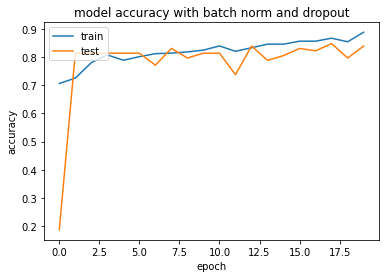

In [16]:
# summarize history for accuracy
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('model accuracy with batch norm and dropout')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

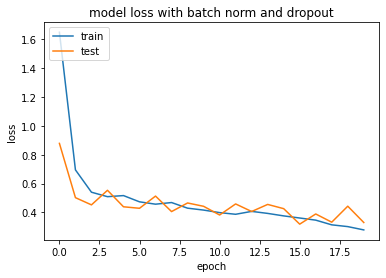

In [17]:
# summarize history for loss
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])
plt.title('model loss with batch norm and dropout')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
val_dataset_lables = validation_generator.labels
val_dataset_lables

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [19]:
classes = train_generator.class_indices
classes = classes.keys()
classes = list(classes)
classes

['Mask', 'NoMask']

In [20]:
file_ids

[41,
 39,
 27,
 35,
 45,
 38,
 32,
 31,
 29,
 9,
 1,
 26,
 24,
 21,
 28,
 7,
 42,
 44,
 25,
 12,
 6,
 43,
 0,
 10,
 19,
 4,
 3,
 18,
 15,
 37,
 14,
 16,
 23,
 2,
 11,
 17,
 30,
 20,
 40,
 13,
 22,
 33,
 34,
 8,
 36,
 5]

In [21]:
pred_test_result = []
for file_id, img in zip(file_ids, test_dataset):
  exp_img = np.expand_dims(img, axis=0)
  val_dataset_pred = model.predict(exp_img)
  pred_val = np.argmax(val_dataset_pred)
  pred_val_lable = classes[pred_val]
  val_dataset_pred_lable = None
  if pred_val_lable == 'Mask':
    val_dataset_pred_lable = 1
  else:
    val_dataset_pred_lable = 0
  result = [file_id,  val_dataset_pred_lable, pred_val_lable]
  #print(val_dataset_pred)
  print(result)
  pred_test_result.append(result)
  print("\n")

[41, 1, 'Mask']


[39, 1, 'Mask']


[27, 1, 'Mask']


[35, 1, 'Mask']


[45, 1, 'Mask']


[38, 1, 'Mask']


[32, 1, 'Mask']


[31, 1, 'Mask']


[29, 1, 'Mask']


[9, 1, 'Mask']


[1, 1, 'Mask']


[26, 1, 'Mask']


[24, 1, 'Mask']


[21, 1, 'Mask']


[28, 1, 'Mask']


[7, 1, 'Mask']


[42, 1, 'Mask']


[44, 0, 'NoMask']


[25, 1, 'Mask']


[12, 1, 'Mask']


[6, 1, 'Mask']


[43, 1, 'Mask']


[0, 1, 'Mask']


[10, 1, 'Mask']


[19, 1, 'Mask']


[4, 1, 'Mask']


[3, 1, 'Mask']


[18, 1, 'Mask']


[15, 1, 'Mask']


[37, 1, 'Mask']


[14, 1, 'Mask']


[16, 1, 'Mask']


[23, 1, 'Mask']


[2, 1, 'Mask']


[11, 1, 'Mask']


[17, 1, 'Mask']


[30, 1, 'Mask']


[20, 1, 'Mask']


[40, 1, 'Mask']


[13, 1, 'Mask']


[22, 1, 'Mask']


[33, 1, 'Mask']


[34, 1, 'Mask']


[8, 1, 'Mask']


[36, 0, 'NoMask']


[5, 1, 'Mask']




In [22]:
pred_test_result_df = pd.DataFrame(pred_test_result, columns=['file_id', 'label', 'label_value'])
pred_test_result_df.sort_values(by='file_id')

,file_id,label,label_value
22,0,1,Mask
10,1,1,Mask
33,2,1,Mask
26,3,1,Mask
25,4,1,Mask
45,5,1,Mask
20,6,1,Mask
15,7,1,Mask
43,8,1,Mask
9,9,1,Mask


In [24]:
subbmit = pred_test_result_df.drop(['label_value'], axis=1)
subbmit.to_csv('HDFC_Hackthon_Submit_5.csv', index=False)

In [ ]:
class DataSet:

  def __init__(self):
    self.training_generator = None
    self.validation_generator = None
    self.testing_set = None
    self.file_ids = None
    self.ground_truth = None

  def put_training_validation_generator(self, training_generator, validation_generator):
    self.training_generator = training_generator
    self.validation_generator = validation_generator

  def put_file_ids(self, file_ids):
    self.file_ids = file_ids
  
  def put_ground_truth(self, ground_truth):
    self.ground_truth = ground_truth
  
  def load_training_validation_data(self):
    return (self.training_generator, self.validation_generator)
  
  def load_file_ids(self):
    return self.file_ids
  
  def load_ground_truth(self):
    return self.ground_truth

  def to_csv(self, dataFrame, versionCode):
    dfc = dataFrame.columns
    if len(dfc) > 2:
      newDataFrame = None
      for c in dfc:
        if c != 'file_id' or c != 'label':
          newDataFrame = dataFrame.drop([c], axis=1)
      newDataFrame.to_csv('HDFC_Hackthon_Submit_{}.csv'.format(versionCode), index=False)
    else:
      dataFrame.to_csv('HDFC_Hackthon_Submit_{}.csv'.format(versionCode), index=False)

In [ ]:
import pickle 

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2, MobileNetV3Large

In [ ]:
mn = MobileNetV2(input_shape=tuple(list(target_size)+[3]),
            weights='imagenet', 
            include_top=False)
mn.trainable = False

In [ ]:
mn.summary()

In [ ]:
model_mn = Sequential()
model_mn.add(mn)
model_mn.add(Flatten())
model_mn.add(Dense(1024,activation='relu'))
model.add(Dropout(.3))
model_mn.add(Dense(512,activation='relu')) 
model.add(Dropout(.3))
model.add(Dense(256,activation='relu')) 
model.add(Dropout(.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model_mn.add(Dense(2,activation='softmax'))

In [ ]:
model_mn.summary()

In [ ]:
model_mn.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  training_history_mn = model_mn.fit(train_generator,steps_per_epoch=len(train_generator) ,epochs=epochs, validation_data=validation_generator, validation_steps=len(validation_generator), verbose=1)

In [ ]:
pred_test_result_mn = []
for file_id, img in zip(file_ids, test_dataset):
  exp_img = np.expand_dims(img, axis=0)
  val_dataset_pred = model.predict(exp_img)
  pred_val = np.argmax(val_dataset_pred)
  pred_val_lable = classes[pred_val]
  val_dataset_pred_lable = None
  if pred_val_lable == 'Mask':
    val_dataset_pred_lable = 1
  else:
    val_dataset_pred_lable = 0
  result = [file_id,  val_dataset_pred_lable, pred_val_lable]
  #print(val_dataset_pred)
  print(result)
  pred_test_result_mn.append(result)
  print("\n")

In [ ]:
pred_test_result_mn_df = pd.DataFrame(pred_test_result_mn, columns=['file_id', 'label', 'label_value'])
pred_test_result_mn_df.sort_values(by='file_id')

In [ ]:
subbmit = pred_test_result_mn_df.drop(['label_value'], axis=1)
subbmit.to_csv('HDFC_Hackthon_Submit_6.csv', index=False)